# Model Evaluation

In [1]:
import sys
sys.path.append("../dataset/")

import datetime
import glob
import json
import matplotlib.pyplot as plt
import nrrd
import numpy as np
import os
import tensorflow as tf
import subprocess
import pickle
from keras_unet_collection import losses
import time

from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from dataset import UltraSoundImages
from keras_unet_collection import models
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops

In [2]:
# Prepare data generator
# raw_dir = "../RawUSGimagesNRRD"
# raw_images = raw_dir + "/data_output"
# raw_masks = raw_dir + "/masks"

raw_dir = "../dataUSGthyroid/samsung_processed"

def get_dataset(dataset_type='samsung', size=(256,256)):
    if dataset_type=='samsung':
        dataset_path = "../dataUSGthyroid/samsung_processed"
    elif dataset_type=='ge':
        dataset_path = "../dataUSGthyroid/GE_processed"
    else:
        return None
    raw_images = dataset_path + "/images"
    raw_masks = dataset_path + "/masks"

    raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
    raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

    TEST_LEN = 16
    VAL_LEN = 4*16
    # TEST_LEN = 5
    # VAL_LEN = 40
    TRAIN_LEN = len(raw_images_paths) - VAL_LEN - TEST_LEN

    batch_size = 16


    validation_images = raw_images_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
    test_images =  raw_images_paths[-TEST_LEN:]

    validation_masks = raw_masks_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
    test_masks =  raw_masks_paths[-TEST_LEN:]

    # train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=size, augment=False)
    val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, dataset_type=dataset_type, size=size, augment=False)
    test_gen = UltraSoundImages(batch_size, test_images, test_masks, dataset_type=dataset_type, size=size, augment=False)
    return val_gen, test_gen

In [3]:
dataset_path = "../dataUSGthyroid/GE_processed"
raw_images = dataset_path + "/images"
raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
len(raw_images_paths)

606

In [4]:
val_samsung_gen, test_samsung_gen = get_dataset("samsung", size=(320,320))
val_ge_gen, test_ge_gen = get_dataset("ge", size=(320,320))

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


In [5]:
images, masks = val_ge_gen.__getitem__(0)
image = images[1]
mask = masks[1]

In [6]:
images

<tf.Tensor: shape=(16, 320, 320, 1), dtype=float32, numpy=
array([[[[3.0244715e-03],
         [1.4188879e-03],
         [8.0901501e-04],
         ...,
         [1.5682445e-03],
         [4.9163220e-03],
         [3.2992493e-03]],

        [[1.5539694e-01],
         [1.4558823e-01],
         [1.4023341e-01],
         ...,
         [2.4418946e-01],
         [2.5992265e-01],
         [1.9396447e-01]],

        [[3.2362899e-01],
         [3.9148858e-01],
         [4.5000097e-01],
         ...,
         [2.9448721e-01],
         [2.9499176e-01],
         [2.8627452e-01]],

        ...,

        [[1.8662971e-01],
         [2.0312500e-01],
         [2.0361806e-01],
         ...,
         [1.4975299e-01],
         [1.4659543e-01],
         [1.6643402e-01]],

        [[1.1242915e-01],
         [1.1676049e-01],
         [1.0973977e-01],
         ...,
         [9.5700249e-02],
         [8.2076252e-02],
         [7.5843483e-02]],

        [[9.5368028e-03],
         [6.5611596e-03],
         [6.347

In [101]:
images.shape

(0,)

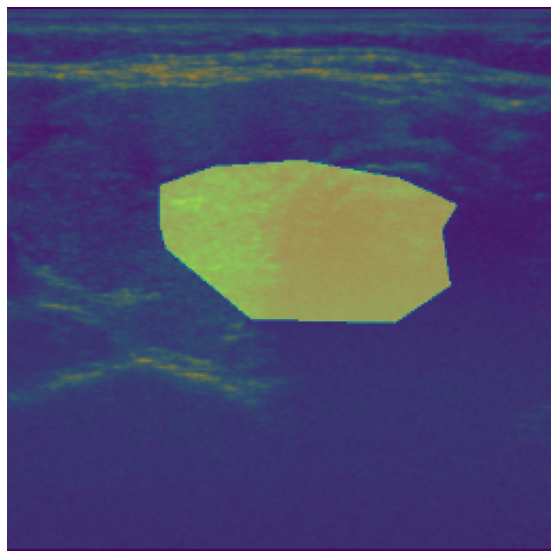

In [105]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
plt.show()

In [5]:
images, masks = val_gen.__getitem__(0)

In [6]:
images.shape

(16, 256, 256, 1)

In [5]:
def custom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'custom_focal_tversky': custom_focal_tversky}

In [6]:
import tensorflow.keras.backend as K

def custom_focal_tversky(y_true, y_pred, alpha=0.7, gamma=4/3):
    return losses.focal_tversky(y_true, y_pred, alpha=alpha, gamma=gamma)

custom_objects = {'custom_focal_tversky': custom_focal_tversky}

class ModelTester:
    
    def __init__(self, path_to_model, 
                 custom_objects, 
                 ds,
                 dataset_type='samsung',
                 size=(256,256), 
                 filter_masks=False, 
                 from_checkpoint=False):
        self.path_to_model = path_to_model
        self.custom_objects = custom_objects
        self.base_path = f'output/{path_to_model}'
        self.model_name = self.base_path.split('/')[1]
        self.model_type = self.base_path.split('/')[3]
        if from_checkpoint:
            self.model_path = f'{self.base_path}checkpoint'
        else:
            self.model_path = f'{self.base_path}model/model'
        self.meta_path = f'{self.base_path}meta/'
        # self.images, self.masks = ds_gen.__getitem__(1)
        self.dataset_type = dataset_type
        # self.ds, _ = get_dataset(dataset_type, size)
        self.ds = ds
        self.images, self.masks = self.ds.__getitem__(1)
        
        gpus = tf.config.list_logical_devices('GPU')
        strategy = tf.distribute.MirroredStrategy(gpus)
        with strategy.scope():
            model = tf.keras.models.load_model(self.model_path, custom_objects=self.custom_objects)
            self.predictions = model.predict(self.images) # Mock predictions
            
        # print(model.summary())
            
        if filter_masks:
            self.filtered_predictions = []
            for pred in self.predictions:
                self.filtered_predictions.append(np.array(self.get_largest_mask(pred)))
                                                 
    def create_report(self, model_summary=False, custom_objects=None, plot_history=True, rm_small_masks=False):
        model_path = f'{self.base_path}model/model'
        meta_path = f'{self.base_path}meta/'
        
        if plot_history:
            self.history = json.load(open(self.meta_path+'history.json'))
            self.plot_history()
        self.plot_us_images(rm_small_masks)
        
        dice_value = self.dice_coef(self.masks, self.predictions)
        print(f'Dice coefficient={dice_value}')
        
        accuracy, precision, recall, f1 = self.basic_metrics(self.masks, self.predictions)
        print(f'accuracy={accuracy}, precision={precision}, recall={recall}, f1={f1}')
        
        loss_val = custom_focal_tversky(self.masks, self.predictions)
        print(f'loss={loss_val}')

        y_true = np.round(self.masks).astype(int).flatten()
        y_pred = np.round(self.predictions).astype(int).flatten()
        cmat = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix(cmat)
        
        if model_summary:
            print(model.summary())
    
    
    def plot_us_images(self, rm_small_masks=False):
        cols = 3 if rm_small_masks else 2
        
        image_id = 0
        plt.figure(figsize=(18, 10))
        for i in range(0, 4):
            plt.subplot(cols, 4, i+1)
            plt.imshow(self.images[i])
            plt.imshow(self.masks[i], alpha=0.5)
            plt.title('Original')
            
            plt.subplot(cols, 4, i+5)
            plt.imshow(self.images[i])
            plt.imshow(self.predictions[i], alpha=0.5)
            plt.title('Predicted')
            
            if rm_small_masks:
                plt.subplot(cols, 4, i+9)
                plt.imshow(self.images[i])
                large_mask = self.get_largest_mask(self.predictions[i])
                plt.imshow(large_mask, alpha=0.5)
                plt.title('Predicted without small masks')
            image_id += 1
        plt.show()

    
    def plot_history(self):
        # Extract the history values
        loss = self.history['loss']
        acc = self.history['accuracy']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_accuracy']
        # mean_io_u = self.history['mean_io_u']
        # val_mean_io_u = self.history['val_mean_io_u']
        
        plt.figure(figsize=(18, 15))
        plt.subplot(3, 1, 1)
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Training', 'Validation'])

        plt.subplot(3, 1, 2)
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Training', 'Validation'])
        
        # plt.subplot(3, 1, 3)
        # plt.plot(mean_io_u)
        # plt.plot(val_mean_io_u)
        # plt.title('Dice Coeff')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.legend(['Training', 'Validation'])
        
        plt.show()
    
        
    def dice_coef(self, y_true, y_pred, smooth=100):        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    
    def calculate_segmentation_metrics(self, y_true, y_pred):
        """
        Calculates TP, TN, FP, FN values for binary segmentation.
        """
        # Convert to numpy arrays of int type
        # y_true = np.array(y_true, dtype=int).flatten()
        # y_pred = np.array(y_pred, dtype=int).flatten()
    
        y_true = np.round(y_true).astype(int).flatten()
        y_pred = np.round(y_pred).astype(int).flatten()

        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        return TP, TN, FP, FN
    
    
    def basic_metrics(self, y_true, y_pred):
        TP, TN, FP, FN = self.calculate_segmentation_metrics(y_true, y_pred)
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        
        return accuracy, precision, recall, f1


    def plot_confusion_matrix(self, cmat):
        plt.figure(figsize = (6,6))
        labels = ['0', '1']
        annot = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cmat.flatten()]
        annot = [f'{v1}\n{v2}' for v1, v2 in zip(annot, group_counts)]
        annot = np.asarray(annot).reshape(2,2)
        sns.heatmap(cmat, cmap='Blues', fmt='', xticklabels=labels, yticklabels=labels, annot=annot)

        plt.xlabel("predictions")
        plt.ylabel("real values")
        plt.show()
        
        
    def class_histogram(self):
        pass
        
    def plot_roc(self):
        return None
    
        
    def mean_iou(self):
        
        return None
        

    def get_largest_mask(self, segmentation_output):
        labeled_output = label(segmentation_output)
        props = regionprops(labeled_output)
        largest_mask_index = np.argmax([prop.area for prop in props])
        largest_mask = labeled_output == (largest_mask_index + 1)
        return largest_mask
    
    
    @staticmethod
    def calculate_full_metrics():
        pass
        
# u2net_2d_tester = ModelTester('unet_2d/samsung/test/', val_gen, custom_objects)
# u2net_2d_tester.create_report(rm_small_masks=True)

## Classic U-Net

### Samsung on Samsung

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

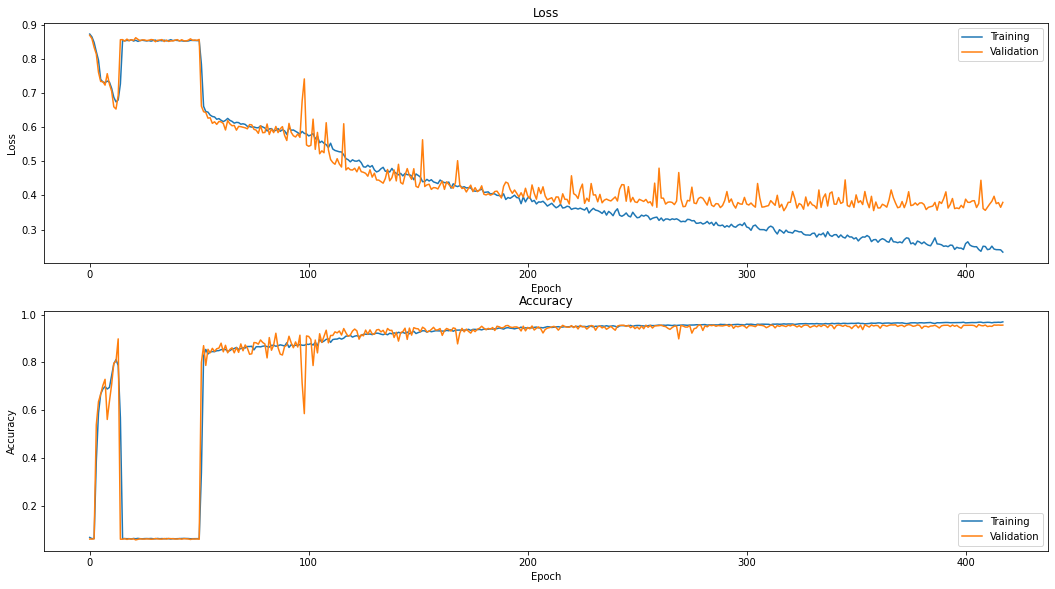

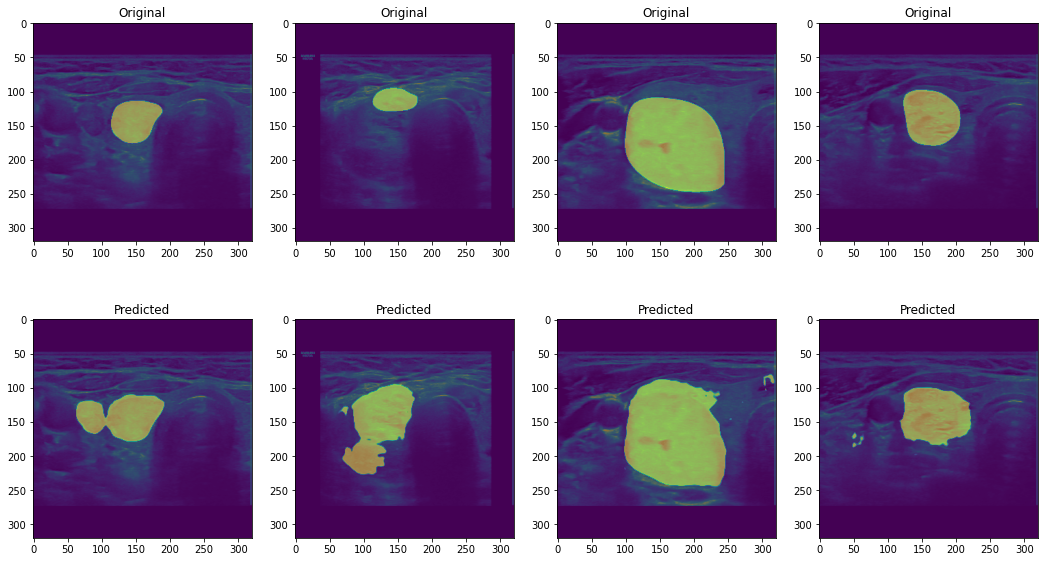

Dice coefficient=0.7841756343841553
accuracy=0.965780029296875, precision=0.6824010182890065, recall=0.9216612377850163, f1=0.7841872281458101
loss=0.26019027829170227


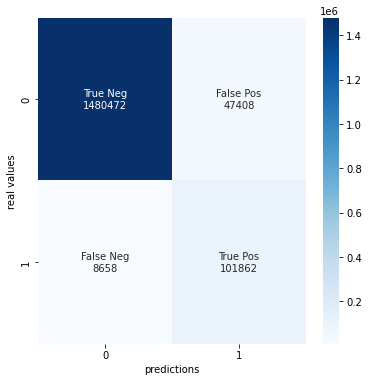

In [6]:
# unet_2d_tester = ModelTester('unet_2d/samsung/test/', custom_objects, dataset_type='samsung')
# unet_2d_tester.create_report(rm_small_masks=True)

u2net_2d_tester = ModelTester('unet_2d/samsung/size_320_model_1/', custom_objects, ds=val_samsung_gen, size=(320, 320))
u2net_2d_tester.create_report(plot_history=True)

### GE on GE

In [12]:
# unet_2d_tester = ModelTester('unet_2d/ge/size_320_model_1/', custom_objects, ds=val_ge_gen, size=(320, 320))
# unet_2d_tester.create_report(plot_history=True)

### Samsung on GE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


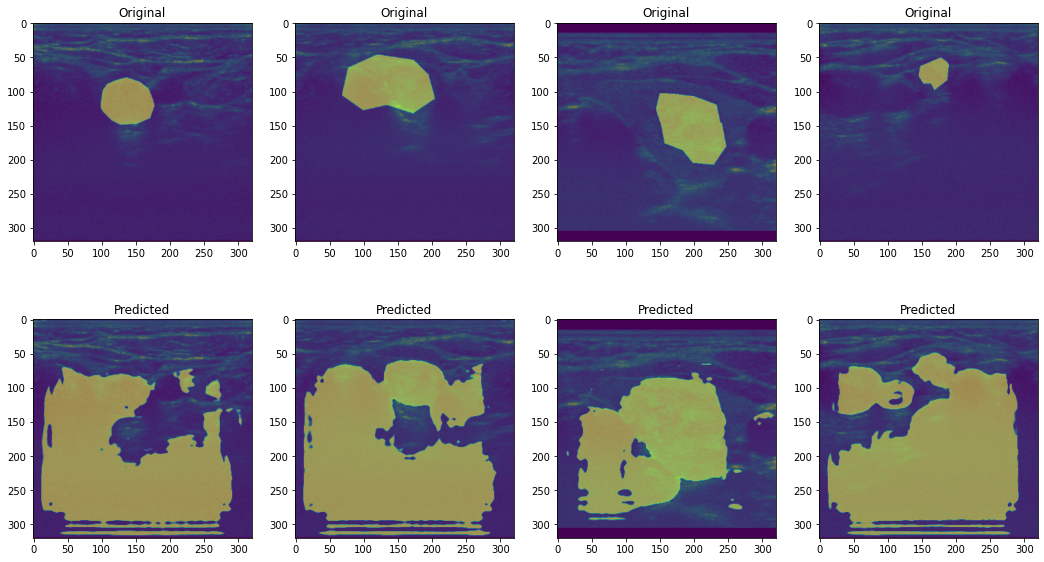

Dice coefficient=0.1952584832906723
accuracy=0.605611572265625, precision=0.11410876599264332, recall=0.674560542671694, f1=0.1951978358127161
loss=0.7875823378562927


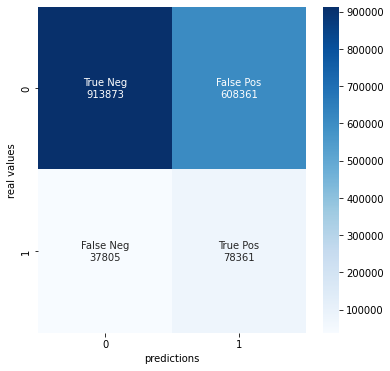

In [13]:
unet_2d_tester = ModelTester('unet_2d/samsung/size_320_model_1/', custom_objects, ds=val_ge_gen, size=(320, 320))
unet_2d_tester.create_report(plot_history=False)

### GE on Samsung

In [ ]:
# unet_2d_tester = ModelTester('unet_2d/ge/test/', custom_objects, dataset_type='samsung')
# unet_2d_tester.create_report(plot_history=False, rm_small_masks=True)

## U^2-Net

### Samsung

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


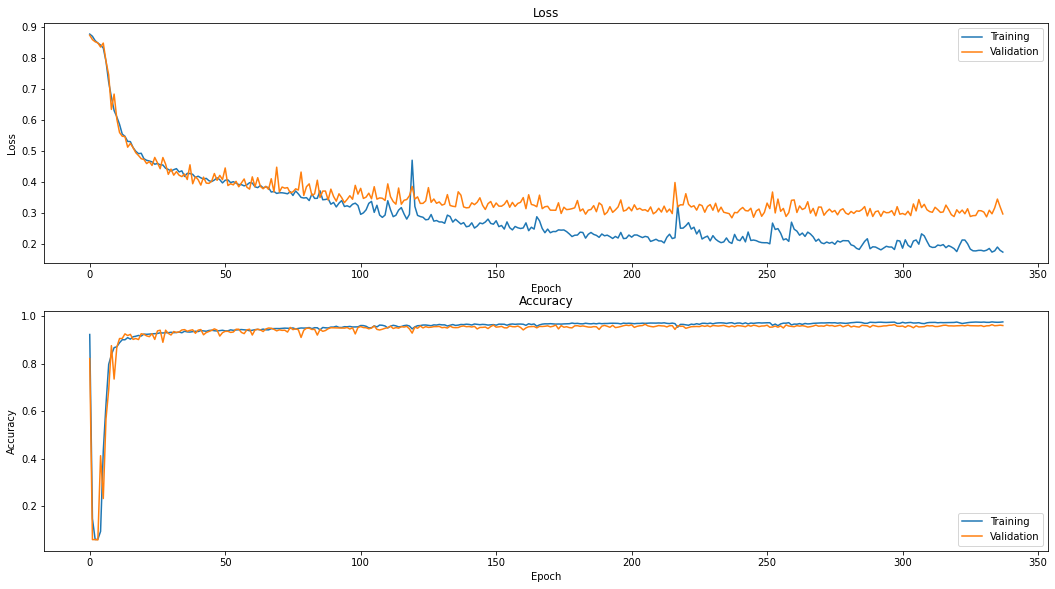

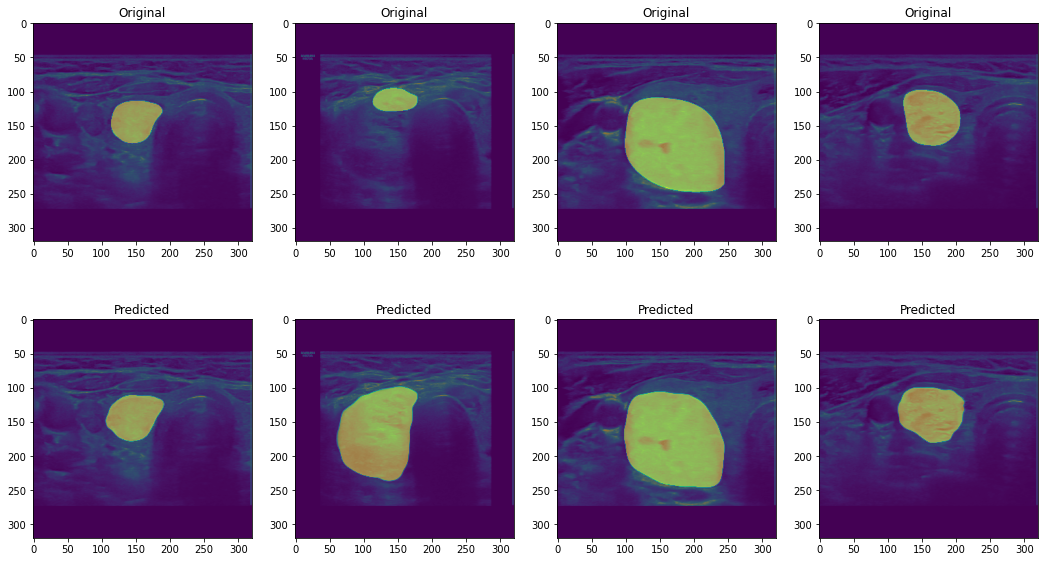

Dice coefficient=0.8424453735351562
accuracy=0.9763177490234375, precision=0.7612314327133918, recall=0.9454849800941006, f1=0.8434123918947823
loss=0.2031802237033844


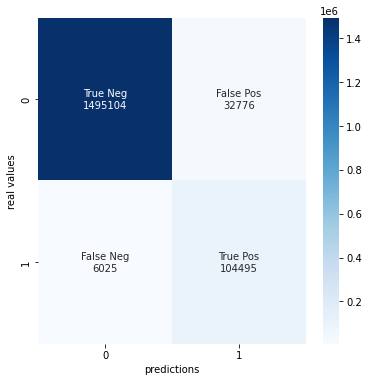

In [16]:
# u2net_2d_tester = ModelTester('u2net_2d/samsung/test/', val_gen, custom_objects, dataset_type='samsung')
u2net_2d_tester = ModelTester('u2net_2d/samsung/size_320_model_1/', custom_objects, dataset_type='samsung', size=(320, 320))
u2net_2d_tester.create_report(plot_history=True)

### GE

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


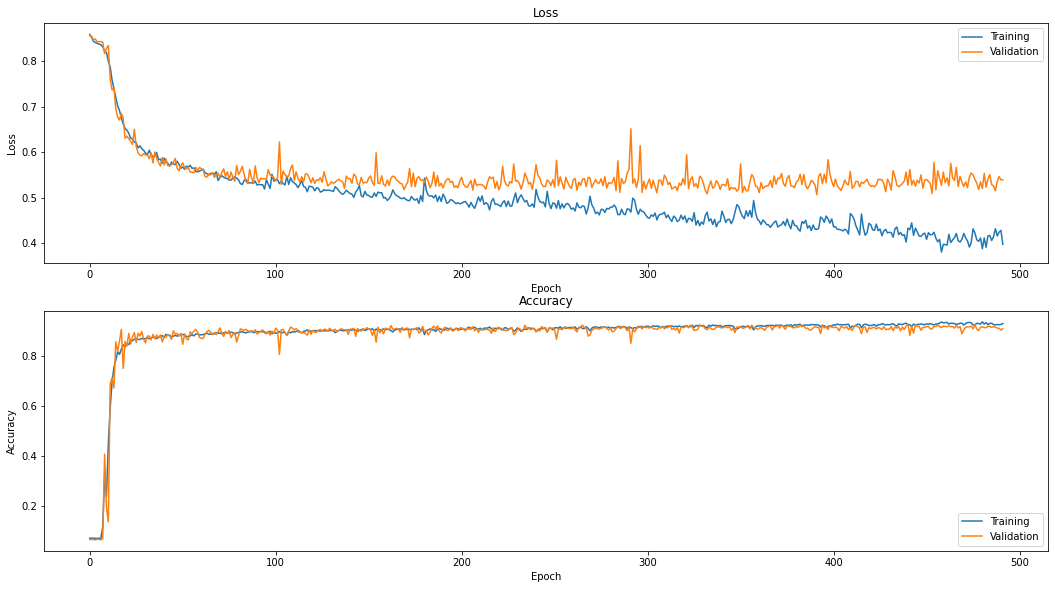

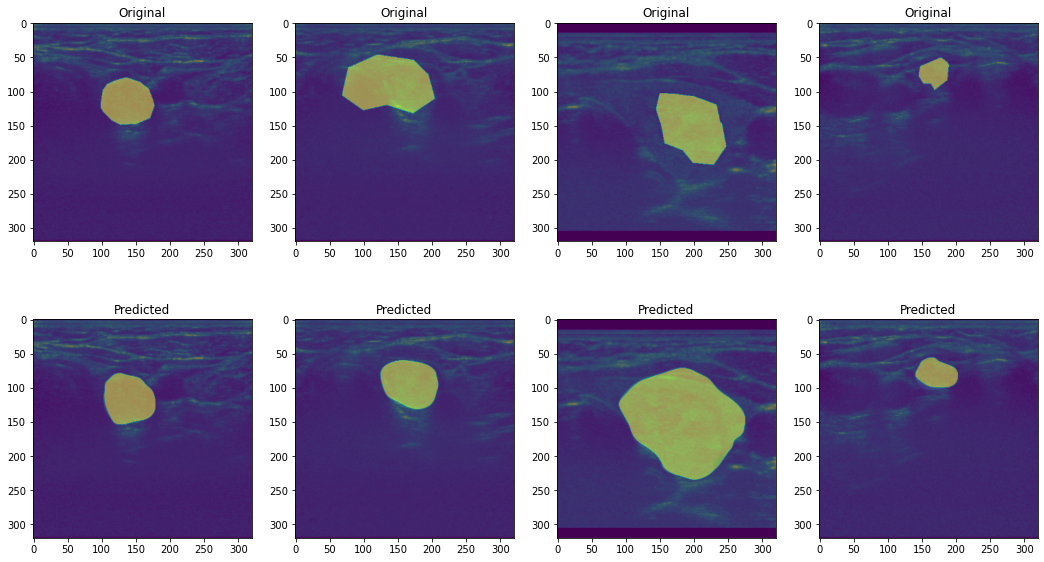

Dice coefficient=0.400137335062027
accuracy=0.9099517822265625, precision=0.3794714556869616, recall=0.42508995747464834, f1=0.4009874257502122
loss=0.6737614870071411


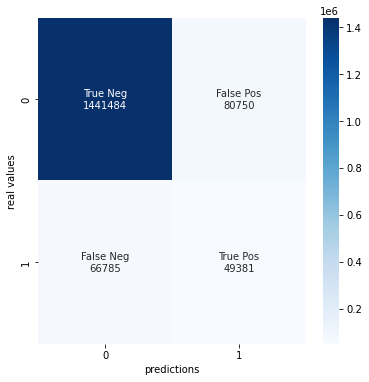

In [19]:
# u2net_2d_tester = ModelTester('u2net_2d/samsung/test/', val_gen, custom_objects, dataset_type='samsung')
u2net_2d_tester = ModelTester('u2net_2d/ge/size_320_model_1/', custom_objects, dataset_type='ge', size=(320, 320))
u2net_2d_tester.create_report()

## Samsung on GE

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


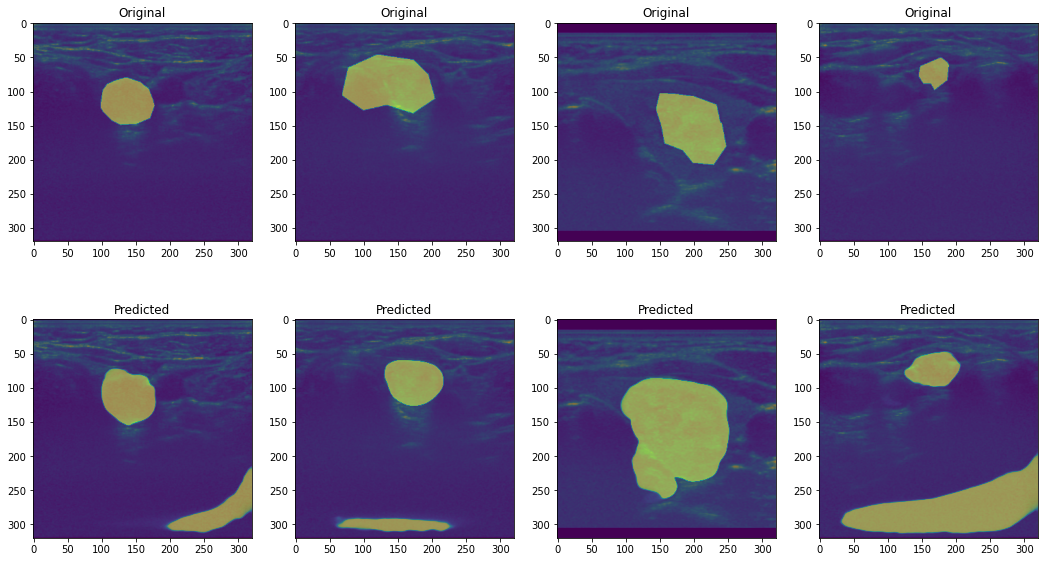

Dice coefficient=0.19286777079105377
accuracy=0.70402099609375, precision=0.11932496211479938, recall=0.49752939758621284, f1=0.1924852295661789
loss=0.8016395568847656


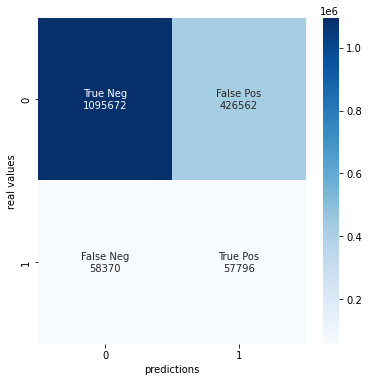

In [21]:
u2net_2d_tester = ModelTester('u2net_2d/samsung/size_320_model_1/', custom_objects, dataset_type='ge', size=(320, 320))
u2net_2d_tester.create_report(plot_history=False)

### GE on Samsung

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


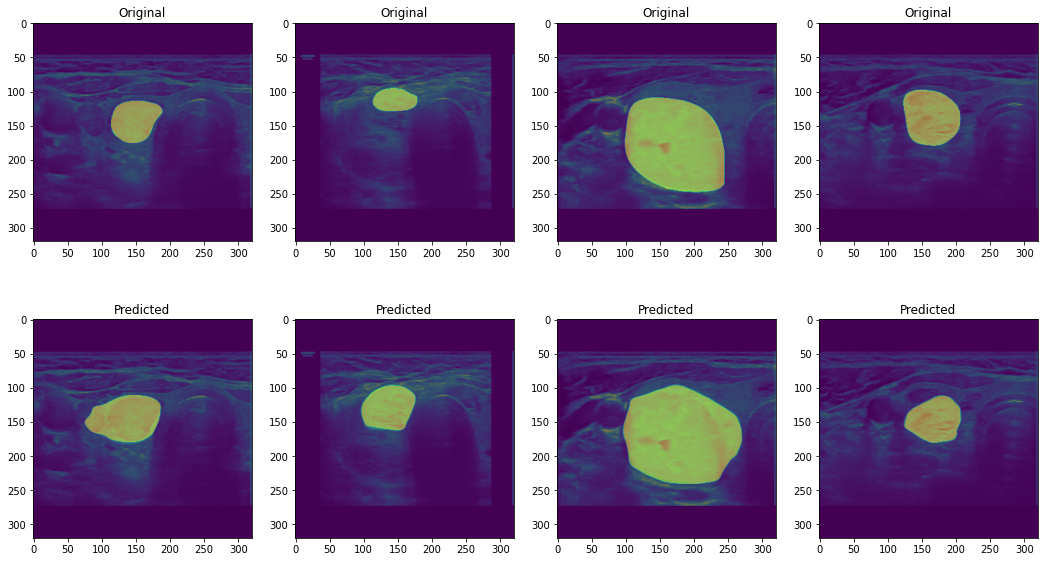

Dice coefficient=0.7008997201919556
accuracy=0.955245361328125, precision=0.637245206712816, recall=0.7812884545783568, f1=0.7019534838347788
loss=0.3741992712020874


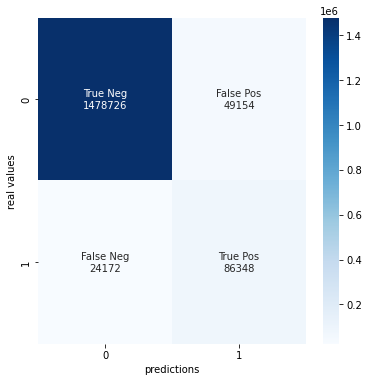

In [22]:
# u2net_2d_tester = ModelTester('u2net_2d/samsung/test/', val_gen, custom_objects, dataset_type='samsung')
u2net_2d_tester = ModelTester('u2net_2d/ge/size_320_model_1/', custom_objects, dataset_type='samsung', size=(320, 320))
u2net_2d_tester.create_report(plot_history=False)

## Unet-3D+

### Samsung

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

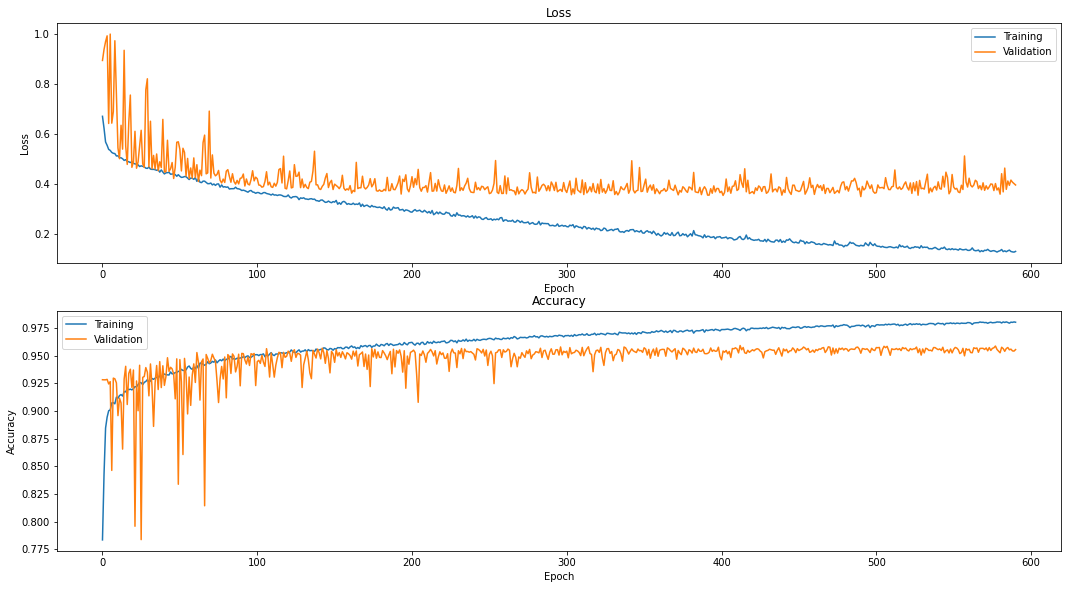

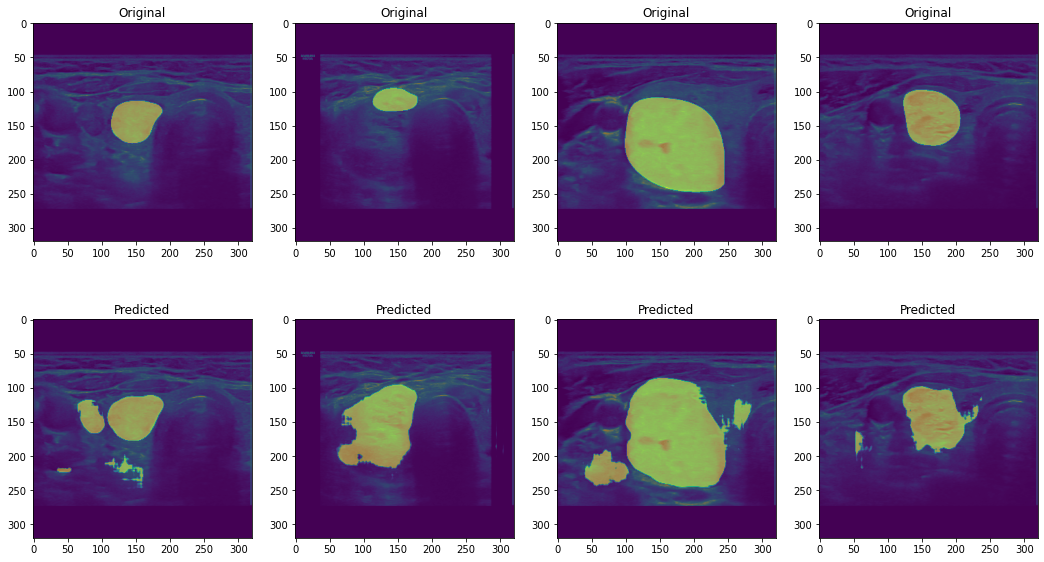

Dice coefficient=0.7455118894577026
accuracy=0.9580474853515625, precision=0.6303264320780493, recall=0.9142870068765834, f1=0.7462051700519515
loss=0.29363563656806946


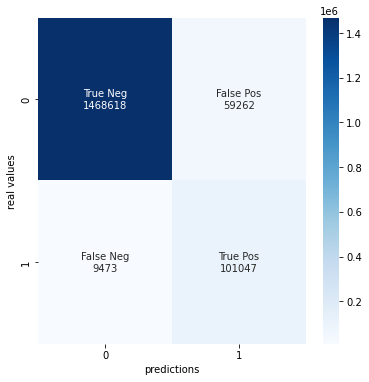

In [8]:
unet_3plus_2d_tester = ModelTester('unet_3plus_2d/samsung/size_320_model_1/', custom_objects=custom_objects, ds=val_samsung_gen)
unet_3plus_2d_tester.create_report()

### GE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


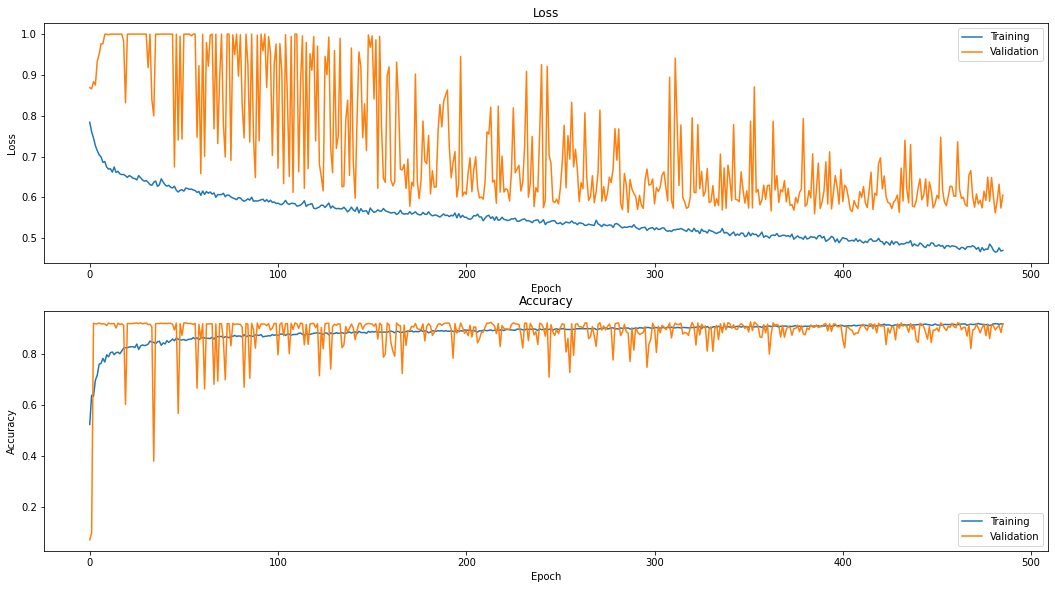

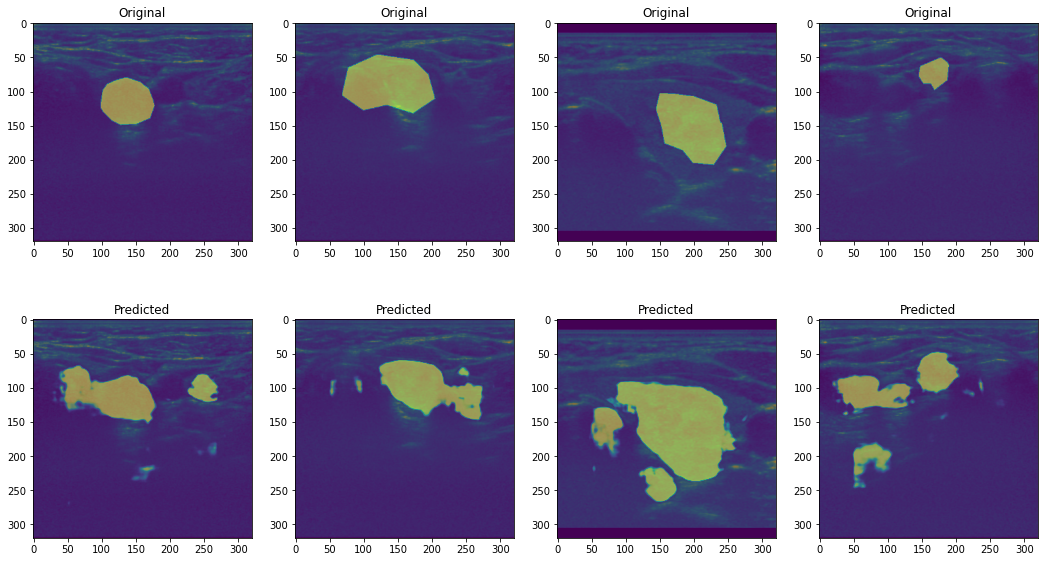

Dice coefficient=0.3190034329891205
accuracy=0.8770404052734375, precision=0.2625013226702903, recall=0.40575555670333835, f1=0.31877373388293934
loss=0.7246323823928833


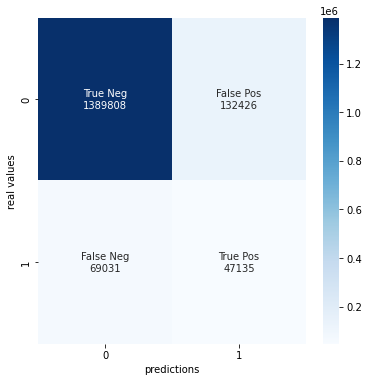

In [34]:
unet_3plus_2d_tester = ModelTester('unet_3plus_2d/ge/size_320_model_1/', custom_objects, ds=val_ge_gen)
unet_3plus_2d_tester.create_report()

## Samsung on GE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


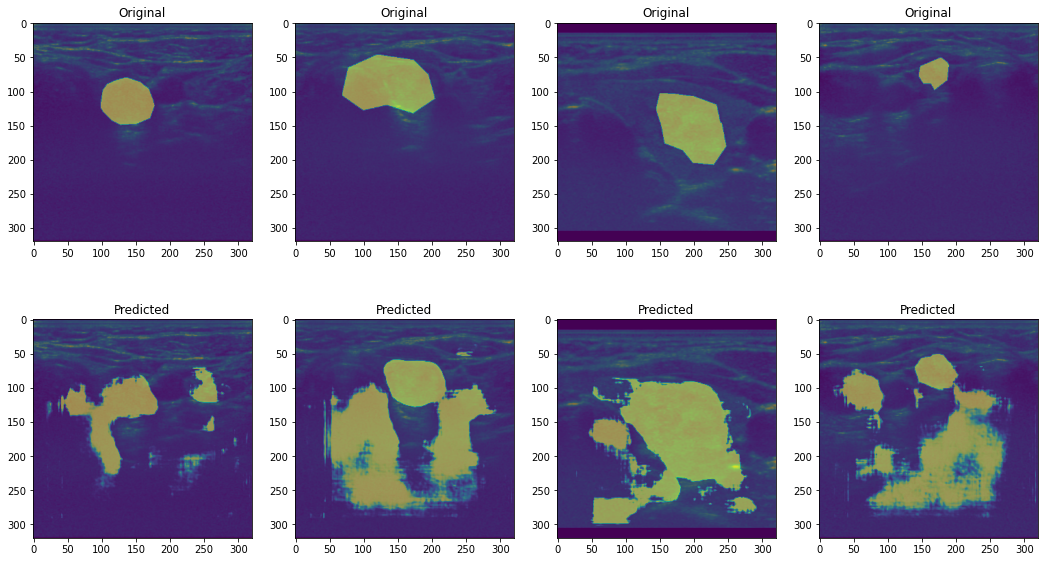

Dice coefficient=0.25991541147232056
accuracy=0.759398193359375, precision=0.16716943909749954, recall=0.6010708813250004, f1=0.26158658799288187
loss=0.7358412146568298


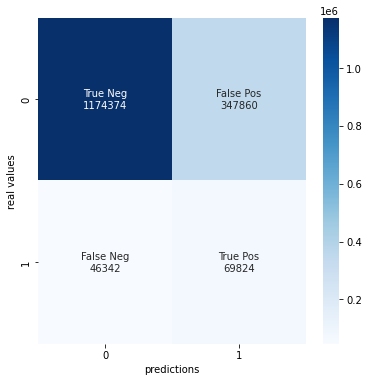

In [36]:
unet_3plus_2d_tester = ModelTester('unet_3plus_2d/samsung/size_320_model_1/', custom_objects=custom_objects, ds=val_ge_gen)
unet_3plus_2d_tester.create_report(plot_history=False)

## GE on Samsung

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


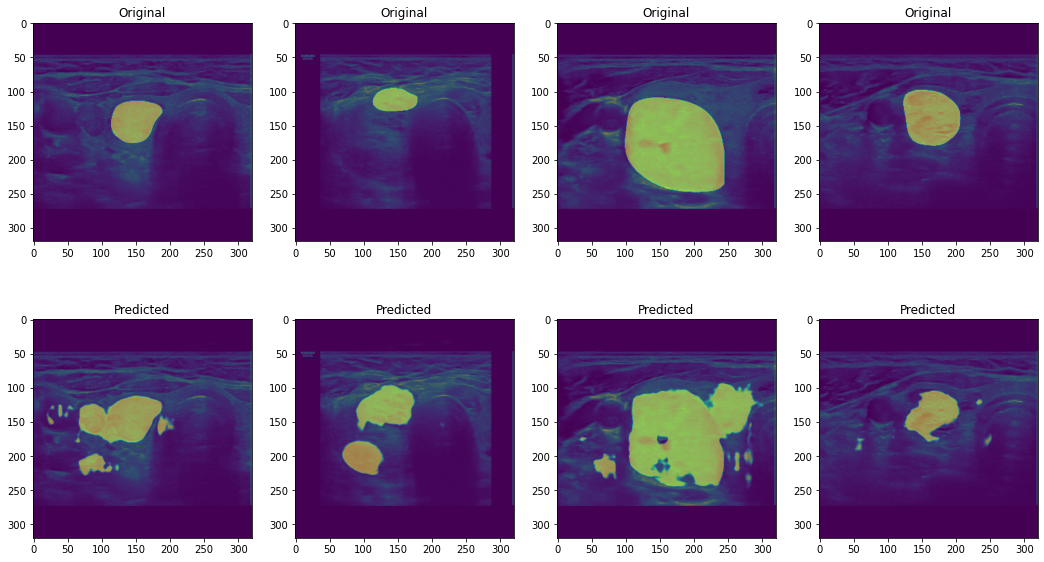

Dice coefficient=0.6764910221099854
accuracy=0.9474444580078125, precision=0.5776618418959758, recall=0.8215164676076728, f1=0.6783391546349391
loss=0.37699615955352783


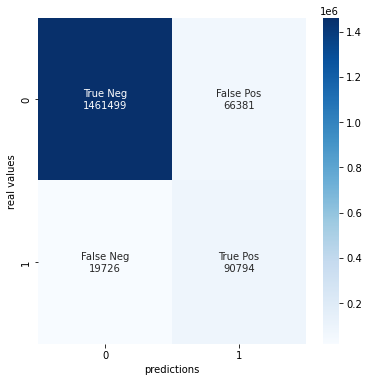

In [37]:
unet_3plus_2d_tester = ModelTester('unet_3plus_2d/ge/size_320_model_1/', custom_objects=custom_objects, ds=val_samsung_gen)
unet_3plus_2d_tester.create_report(plot_history=False)

## Trans-Unet

### Samsung

In [14]:
# transunet_2d_tester = ModelTester('transunet_2d/samsung/size_256_model_1/', custom_objects, dataset_type='samsung')
# transunet_2d_tester.create_report()

In [15]:
# transunet_2d_tester.model.summary()

## GE

In [38]:
# transunet_2d_tester = ModelTester('transunet_2d/ge/size_256_model_1/', custom_objects, dataset_type='ge')
# transunet_2d_tester.create_report()

### Samsung on GE

In [39]:
# transunet_2d_tester = ModelTester('transunet_2d/samsung/test/', custom_objects, dataset_type='ge')
# transunet_2d_tester.create_report()

## GE on Samsung

Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


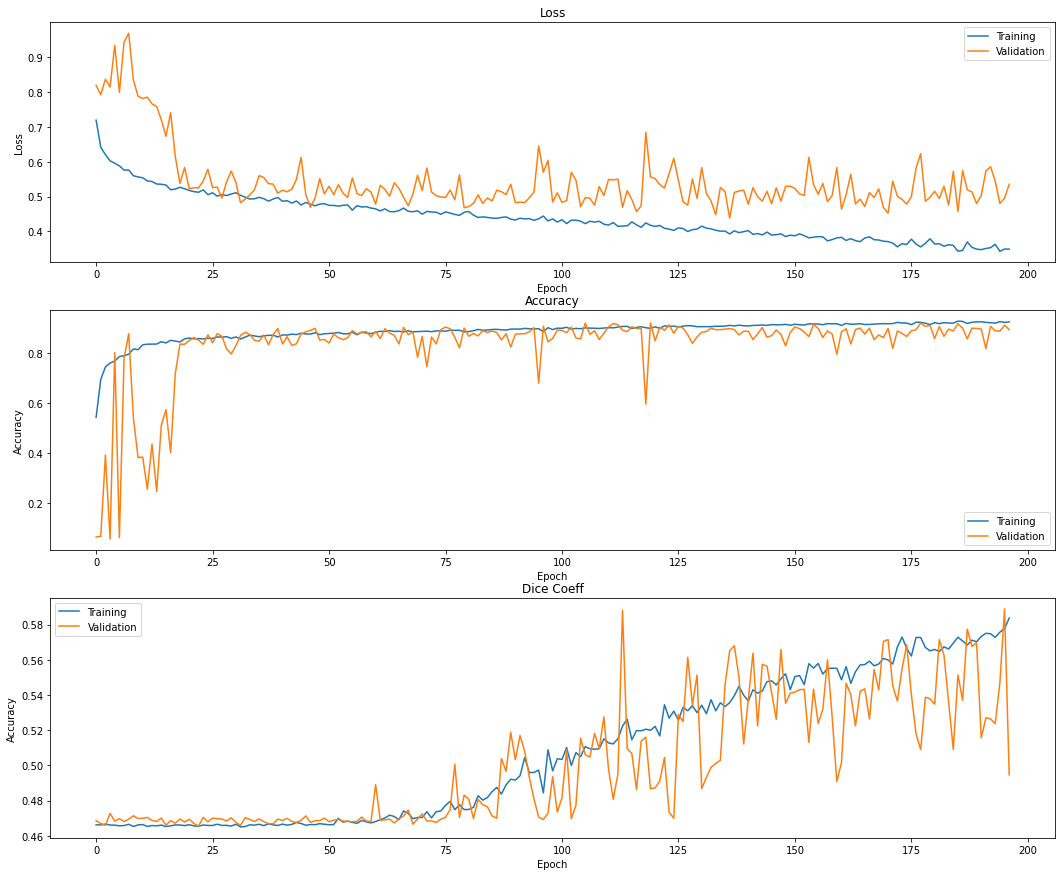

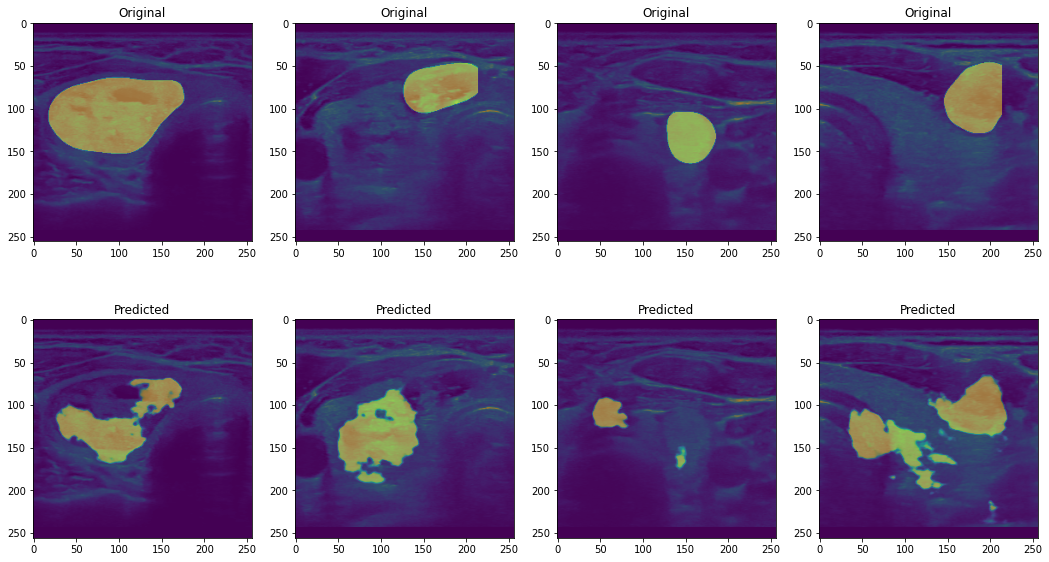

Dice coefficient=0.45975208282470703
accuracy=0.9012222290039062, precision=0.5646827725197071, recall=0.3892963295168751, f1=0.46086739261696064
loss=0.6694743633270264


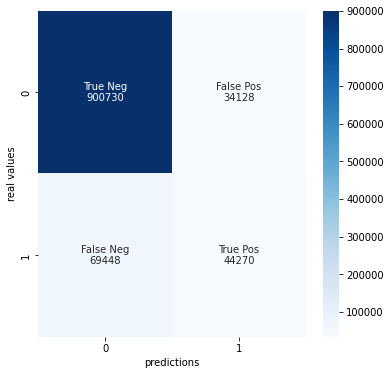

In [55]:
transunet_2d_tester = ModelTester('transunet_2d/ge/test/', custom_objects, dataset_type='samsung')
transunet_2d_tester.create_report()

## Compare models

In [9]:
import sklearn.metrics as metrics

In [32]:
def plot_roc(output, masks):
    # input_image = np.expand_dims(image, 0)
    labels = []
    plt.figure(figsize=(15, 15))
    plt.plot([0, 1], [0, 1])
    labels.append('baseline')
    # plt.plot([0, 0], [0, 1], color='black')
    for key, value in output.items():
        fpr, tpr, threshold = metrics.roc_curve(np.round(masks).astype(int).flatten(), value['prediction'].flatten())
        # fpr, tpr, threshold = metrics.roc_curve(np.round(images).astype(int), value['prediction'])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        labels.append(f'{key}, auc={round(roc_auc,3)}')
    plt.grid()
    plt.legend(labels)
    plt.show()
    
def plot_comparison(model_paths, images, masks, output, n=0):
    # input_image = np.expand_dims(image, 0)
    
    plt.figure(figsize=(25, 25))
    plt.subplot(1, 5, 1)
    plt.imshow(images[n])
    plt.imshow(masks[n], alpha=0.5)
    plt.title('Original')
    
    for i, m_path in enumerate(model_paths):
        gpus = tf.config.list_logical_devices('GPU')
        strategy = tf.distribute.MirroredStrategy(gpus)
        name = m_path.split('/')[0]
        title = ' '.join(name.split('_')[:-1]).capitalize()

        with strategy.scope():
            model = tf.keras.models.load_model(f'output/{m_path}model/model', custom_objects=custom_objects)
            predictions = model.predict(images)
            output[name] = {}
            output[name]['prediction'] = predictions

        plt.subplot(1, 5, i+2)
        plt.imshow(images[n])
        plt.imshow(predictions[n], alpha=0.5)
        plt.title(title)
    plt.show()

In [11]:
images, masks = val_samsung_gen.__getitem__(0)
image = images[4]
mask = masks[4]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


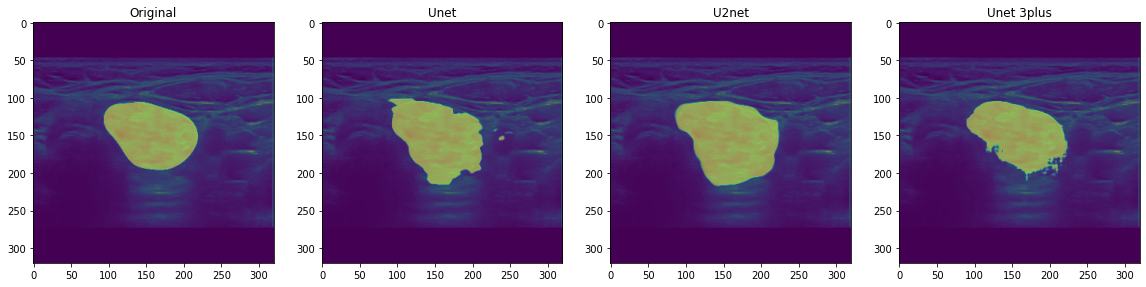

In [12]:
output = {}
# model_paths = ['unet_2d/samsung/test/', 
#                'u2net_2d/samsung/size_256_model_1/', 
#                'unet_3plus_2d/samsung/size_256_model_1/', 
#                'transunet_2d/samsung/test/']

model_paths = ['unet_2d/samsung/size_320_model_1/', 'u2net_2d/samsung/size_320_model_1/', 'unet_3plus_2d/samsung/size_320_model_1/']
plot_comparison(model_paths, images, masks, output, n=10)

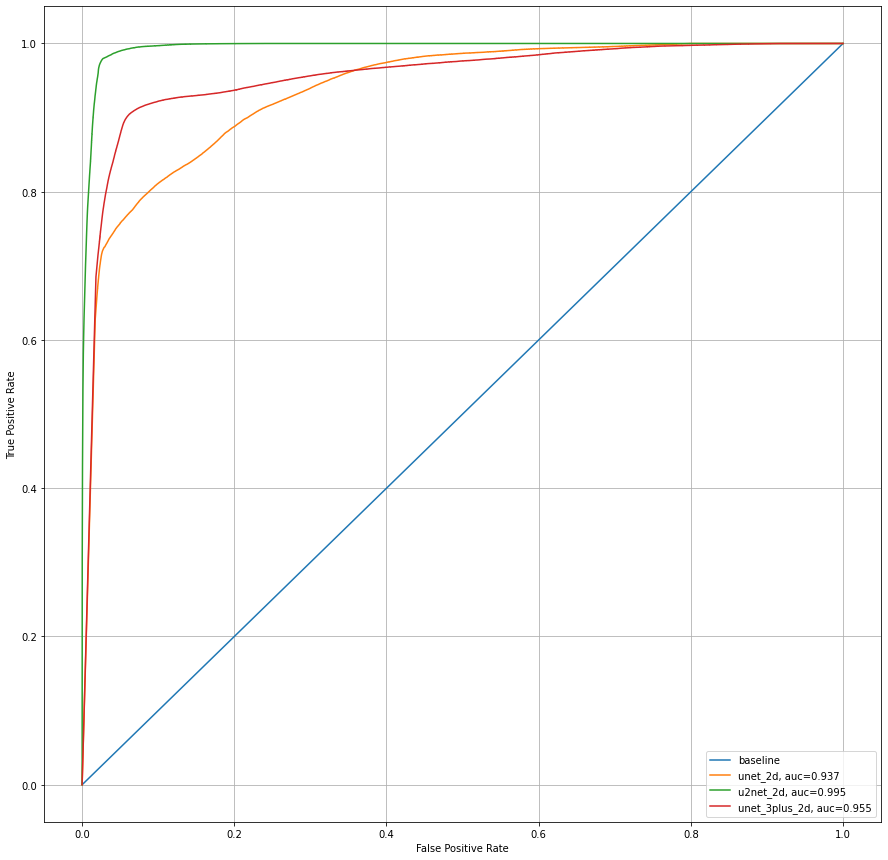

In [33]:
plot_roc(output, masks)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


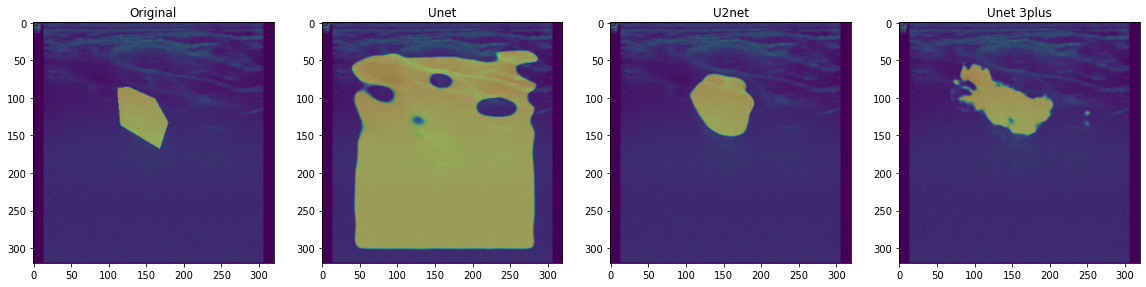

In [25]:
images, masks = val_ge_gen.__getitem__(0)
image = images[0]
mask = masks[0]

output = {}
model_paths = ['unet_2d/ge/size_320_model_1/', 'u2net_2d/ge/size_320_model_1/', 'unet_3plus_2d/ge/size_320_model_1/', ]
plot_comparison(model_paths, images, masks, output, n=10)

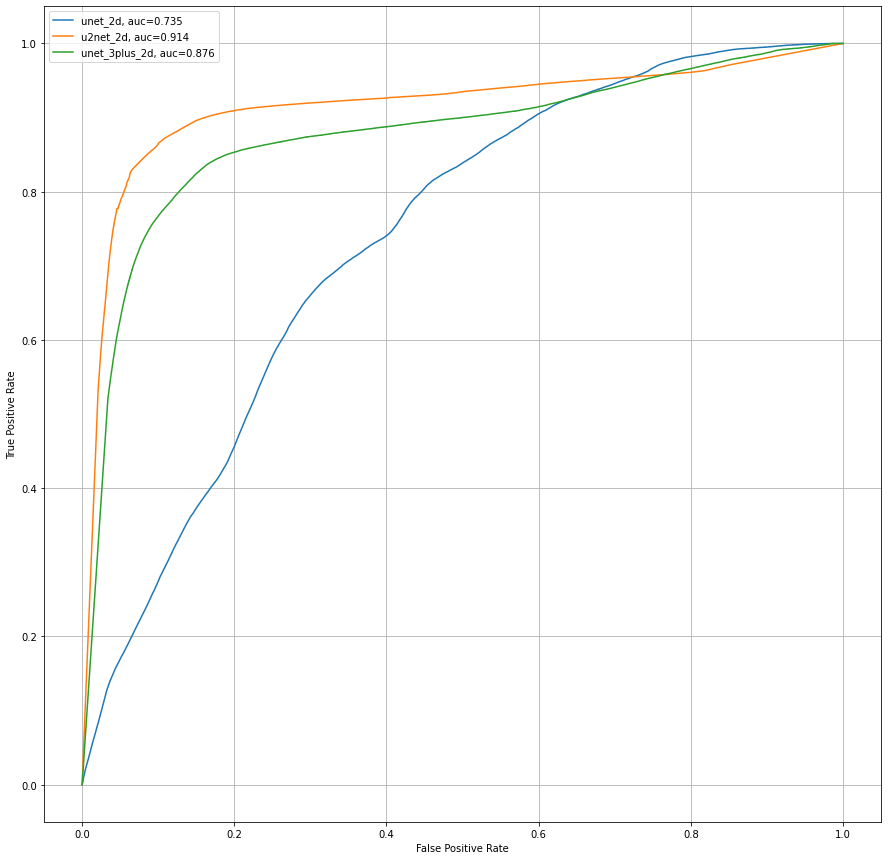

In [26]:
plot_roc(output, masks)